In [113]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [114]:
# Load the Training Dataset
train = pd.read_excel('credit-data-training.xlsx')  
print(train.head())

  Credit-Application-Result Account-Balance  Duration-of-Credit-Month  \
0              Creditworthy    Some Balance                         4   
1              Creditworthy    Some Balance                         4   
2              Creditworthy    Some Balance                         4   
3              Creditworthy    Some Balance                         4   
4              Creditworthy      No Account                         6   

  Payment-Status-of-Previous-Credit       Purpose  Credit-Amount  \
0                           Paid Up         Other           1494   
1                           Paid Up  Home Related           1494   
2        No Problems (in this bank)  Home Related           1544   
3        No Problems (in this bank)  Home Related           3380   
4                           Paid Up  Home Related            343   

  Value-Savings-Stocks Length-of-current-employment  Instalment-per-cent  \
0           £100-£1000                        < 1yr                    1   


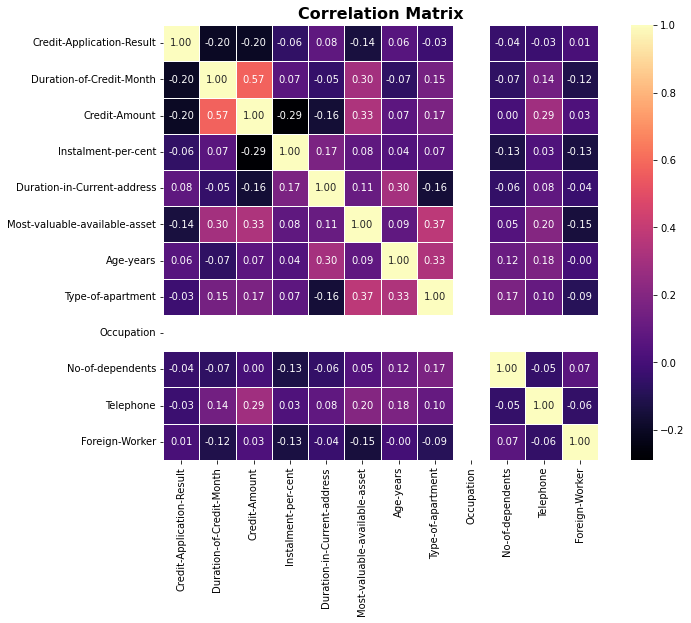

In [115]:
# Correlation Analysis
train['Credit-Application-Result'] = train['Credit-Application-Result'].replace({'Creditworthy': 1, 'Non-Creditworthy': 0})
correlation_matrix = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma', square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

In [116]:
#Data preprocessing

X = train.drop('Credit-Application-Result', axis=1)  # Features
y = train['Credit-Application-Result']  # Target variable

# Check for missing values
print("Missing values in each column:\n", X.isnull().sum())

Missing values in each column:
 Account-Balance                        0
Duration-of-Credit-Month               0
Payment-Status-of-Previous-Credit      0
Purpose                                0
Credit-Amount                          0
Value-Savings-Stocks                   0
Length-of-current-employment           0
Instalment-per-cent                    0
Guarantors                             0
Duration-in-Current-address          344
Most-valuable-available-asset          0
Age-years                             12
Concurrent-Credits                     0
Type-of-apartment                      0
No-of-Credits-at-this-Bank             0
Occupation                             0
No-of-dependents                       0
Telephone                              0
Foreign-Worker                         0
dtype: int64


In [117]:
# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Impute missing values for numeric features with mean
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# Impute missing values for categorical features with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Train a Random Forest model for initial feature importance
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)

RandomForestClassifier(random_state=42)

In [118]:
# Get feature importances
importances = rfc.feature_importances_
feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Dropping less important features based on EDA
features_to_drop = low_importance_features['Features'].tolist()
print(f"Dropping the following features due to low importance: {features_to_drop}")
X.drop(columns=features_to_drop, inplace=True)

# Display the shape of X after dropping low importance features
print(f"Shape of X after dropping low importance features: {X.shape}")

Dropping the following features due to low importance: ['Payment-Status-of-Previous-Credit_Some Problems', 'Duration-in-Current-address', 'Value-Savings-Stocks_None', 'Type-of-apartment', 'Telephone', 'Length-of-current-employment_< 1yr', 'No-of-dependents', 'Payment-Status-of-Previous-Credit_Paid Up', 'No-of-Credits-at-this-Bank_More than 1', 'Value-Savings-Stocks_£100-£1000', 'Purpose_Used car', 'Guarantors_Yes', 'Length-of-current-employment_4-7 yrs', 'Purpose_New car', 'Foreign-Worker', 'Purpose_Other', 'Occupation']
Shape of X after dropping low importance features: (500, 6)


In [119]:
# Splitting the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [120]:
# Random Forest Classifier before Hyperparameter Tuning
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('Train Score before tuning: {:.2f}'.format(rfc.score(X_train, y_train)))
print('Test Score before tuning: {:.2f}'.format(rfc.score(X_test, y_test)))

Train Score before tuning: 1.00
Test Score before tuning: 0.78


In [121]:
# Random Forest Classifier after Hyperparameter Tuning
best_params = grid_rfc.best_params_
rfc_tuned = RandomForestClassifier(max_features=best_params['max_features'], 
                                    max_leaf_nodes=best_params['max_leaf_nodes'], 
                                    random_state=0)
rfc_tuned.fit(X_train, y_train)

print('Train Score after tuning: {:.2f}'.format(rfc_tuned.score(X_train, y_train)))
print('Test Score after tuning: {:.2f}'.format(rfc_tuned.score(X_test, y_test)))

Train Score after tuning: 0.81
Test Score after tuning: 0.76


In [122]:
# Hyperparameter tuning for Random Forest Classifier
param_grid = {
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
grid_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5)
grid_rfc.fit(X_train, y_train)

print('Best cross-validation accuracy: {:.2f}'.format(grid_rfc.best_score_))
print('Best test score after tuning: {:.2f}'.format(grid_rfc.score(X_test, y_test)))
print('Best parameters:', grid_rfc.best_params_)

Best cross-validation accuracy: 0.77
Best test score after tuning: 0.76
Best parameters: {'max_features': 2, 'max_leaf_nodes': 8}


In [123]:
# Predictions
rfc_y_pred = rfc_tuned.predict(X_test)
rfc_y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

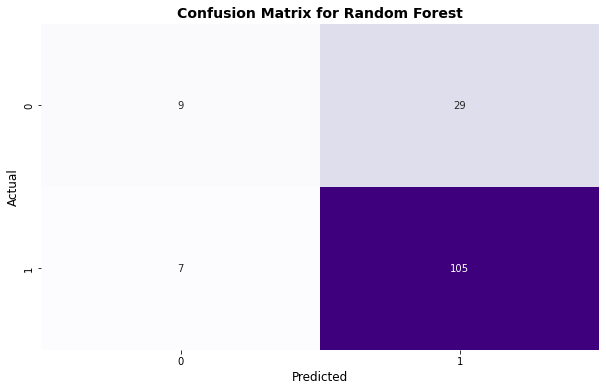

In [125]:
# Confusion Matrix
rf_cm = confusion_matrix(y_test, rfc_y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.title("Confusion Matrix for Random Forest",fontsize=14,fontweight='bold')
plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [126]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, rfc_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.24      0.33        38
           1       0.78      0.94      0.85       112

    accuracy                           0.76       150
   macro avg       0.67      0.59      0.59       150
weighted avg       0.73      0.76      0.72       150



ROC-AUC Score: 0.7111


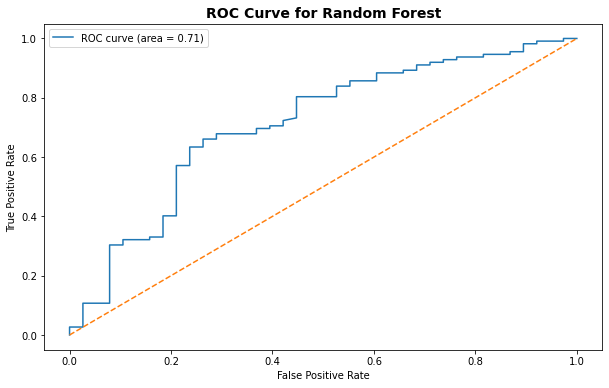

In [127]:
# ROC-AUC Score and ROC Curve
roc_auc = roc_auc_score(y_test, rfc_tuned.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")
fpr, tpr, _ = roc_curve(y_test, rfc_tuned.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest",fontsize=14,fontweight='bold')
plt.legend()
plt.show()

In [128]:
#Implementing the Model on Test Data
test_data = pd.read_excel('customers-to-score.xlsx')
print("Test Data Sample:\n", test_data.head(3))

Test Data Sample:
   Account-Balance  Duration-of-Credit-Month Payment-Status-of-Previous-Credit  \
0      No Account                         9        No Problems (in this bank)   
1      No Account                        12        No Problems (in this bank)   
2      No Account                        24                           Paid Up   

        Purpose  Credit-Amount Value-Savings-Stocks  \
0  Home Related           2799                 None   
1  Home Related           2122                 None   
2  Home Related           3758           £100-£1000   

  Length-of-current-employment  Instalment-per-cent Guarantors  \
0                        < 1yr                    2       None   
1                        < 1yr                    3       None   
2                        < 1yr                    1       None   

   Duration-in-Current-address  Most-valuable-available-asset  Age-years  \
0                            2                              1         36   
1                 

In [129]:
print("Missing values in test data:\n", test_data.isnull().sum())

Missing values in test data:
 Account-Balance                      0
Duration-of-Credit-Month             0
Payment-Status-of-Previous-Credit    0
Purpose                              0
Credit-Amount                        0
Value-Savings-Stocks                 0
Length-of-current-employment         0
Instalment-per-cent                  0
Guarantors                           0
Duration-in-Current-address          0
Most-valuable-available-asset        0
Age-years                            0
Concurrent-Credits                   0
Type-of-apartment                    0
No-of-Credits-at-this-Bank           0
Occupation                           0
No-of-dependents                     0
Telephone                            0
Foreign-Worker                       0
dtype: int64


In [130]:
# Preprocessing the Test Data

# Replace categories in 'Purpose' column
test_data['Purpose'].replace({'Used car': 'Not Home Related',
                               'New car': 'Not Home Related',
                               'Other': 'Not Home Related'}, inplace=True)

# Dropping columns that are not in the training data
test_data.drop(['Occupation',
                'Duration-in-Current-address',
                'Concurrent-Credits',
                'Telephone',
                'Guarantors',
                'Foreign-Worker',
                'No-of-dependents'], 
               axis=1, inplace=True)

# Convert categorical features to dummy variables
test_data = pd.get_dummies(test_data, columns=['Account-Balance',
                                                'Payment-Status-of-Previous-Credit',
                                                'Purpose',
                                                'Value-Savings-Stocks',
                                                'Length-of-current-employment',
                                                'No-of-Credits-at-this-Bank'], 
                            drop_first=True)

In [131]:
# Ensure test data has the same features as training data
X_train_columns = X_train.columns.tolist()
missing_cols = set(X_train_columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0 # Add missing columns with default value 0

# Reorder the test data columns
test_data = test_data[X_train_columns]  

In [132]:
# Making Predictions using the tuned Random Forest model
test_pred = rfc_tuned.predict(test_data)

# Adding Predictions to the Test Data
test_data['Prediction'] = test_pred
test_data['Prediction'].replace({1: 'Creditworthy', 0: 'Non-Creditworthy'}, inplace=True)

In [133]:
# Display the first 20 predictions
print("First 20 Predictions:\n", test_data['Prediction'].head(20))

First 20 Predictions:
 0         Creditworthy
1         Creditworthy
2         Creditworthy
3         Creditworthy
4         Creditworthy
5         Creditworthy
6         Creditworthy
7         Creditworthy
8     Non-Creditworthy
9         Creditworthy
10        Creditworthy
11        Creditworthy
12        Creditworthy
13        Creditworthy
14        Creditworthy
15        Creditworthy
16        Creditworthy
17        Creditworthy
18        Creditworthy
19    Non-Creditworthy
Name: Prediction, dtype: object


In [134]:
# Display counts of predictions
print("Counts of Predictions:\n", test_data['Prediction'].value_counts())

Counts of Predictions:
 Creditworthy        445
Non-Creditworthy     55
Name: Prediction, dtype: int64
